1. IMPORT LIBRARY YANG DIPERLUKAN

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

2. MENGGABUNGKAN DATA FITUR PPG DAN GSR SESUAI SESI

In [35]:
# Path ke file CSV data PPG dan GSR
ppg_file_path = 'data uji/Reza/sesi 4/features.csv'  # Path file PPG
gsr_file_path = 'Data Uji Fitur GSR/sesi 4/Reza_features.csv'  # Path file GSR

# Membaca data PPG dan GSR
ppg_data = pd.read_csv(ppg_file_path)
gsr_data = pd.read_csv(gsr_file_path)

# Pastikan jumlah baris sama
min_rows = min(len(ppg_data), len(gsr_data))
ppg_data_trimmed = ppg_data.head(min_rows)
gsr_data_trimmed = gsr_data.head(min_rows)

# Gabungkan dataset
merged_data = pd.concat([ppg_data_trimmed.reset_index(drop=True), gsr_data_trimmed.reset_index(drop=True)], axis=1)

# Menghapus kolom 'Label' yang duplikat berdasarkan indeks kolom kedua
merged_data = merged_data.loc[:, ~merged_data.columns.duplicated()]

# Simpan data gabungan
output_path = 'Uji PPGandGSR/Reza_sesi4.csv'
merged_data.to_csv(output_path, index=False)

3. MENYIMPAN FILE CSV YANG SUDAH DIGABUNG KE FOLDER BARU

In [2]:
# Path folder yang berisi file CSV Gabungan Sesi
folder_path = 'Train PPGandGSR/'

# ----------------------------
# 1. Gabungkan semua file CSV dari folder Gabungan Sesi
# ----------------------------
all_data = []

# Pastikan folder_path ada dan berisi file CSV
if os.path.exists(folder_path):
    for file in os.listdir(folder_path):
        if file.endswith('.csv'):  # Memeriksa apakah file berformat .csv
            file_path = os.path.join(folder_path, file)
            try:
                session_data = pd.read_csv(file_path)
                all_data.append(session_data)
            except Exception as e:
                print(f"Error membaca file {file_path}: {e}")
else:
    raise FileNotFoundError(f"Folder {folder_path} tidak ditemukan!")

# Gabungkan semua data menjadi satu DataFrame
if all_data:
    data = pd.concat(all_data, ignore_index=True)
    print("Data berhasil digabung.")
else:
    raise ValueError("Tidak ada data untuk digabungkan. Pastikan file CSV ada di folder yang sesuai.")

Data berhasil digabung.


4. UNDERSTANDING DATASET

In [3]:
print("Dataset Overview:")
print(data.head())
print("\nDataset Info:")
print(data.info())
print("\nStatistical Summary:")
print(data.describe())

Dataset Overview:
     HR_mean        SDNN       RMSSD   pNN50   Label  \
0  74.487622   78.457349   98.234414  0.0050  Normal   
1  71.780518  122.836838  231.192560  0.0050  Normal   
2  72.743157  195.675468  290.000000  0.0025  Normal   
3  61.548994   41.899350   73.824115  0.0025  Normal   
4  93.104679  214.009346  275.771645  0.0050  Normal   

                    Timestamp  Mean SCL   Max SCL  Max SCR Peak  \
0  2024-11-20 15:53:34.095834  0.738292  0.738292           0.0   
1  2024-11-20 15:53:35.096938  0.734473  0.738292           0.0   
2  2024-11-20 15:53:36.097956  0.730989  0.738292           0.0   
3  2024-11-20 15:53:37.098816  0.727829  0.738292           0.0   
4  2024-11-20 15:53:38.099702  0.724979  0.738292           0.0   

   Std Dev SCR Rise Time  Number of SCR Peaks  
0                    0.0                    0  
1                    0.0                    0  
2                    0.0                    0  
3                    0.0                    0  
4 

5. PENGECEKAN NILAI NaN

In [4]:
nan_counts = data.isna().sum()
print("\nJumlah NaN di Setiap Kolom:")
print(nan_counts)


Jumlah NaN di Setiap Kolom:
HR_mean                  0
SDNN                     0
RMSSD                    0
pNN50                    0
Label                    0
Timestamp                0
Mean SCL                 0
Max SCL                  0
Max SCR Peak             0
Std Dev SCR Rise Time    0
Number of SCR Peaks      0
dtype: int64


6. MENGHAPUS TIMESTAMP

In [5]:
data = data.drop('Timestamp', axis=1)
data.head()

,HR_mean,SDNN,RMSSD,pNN50,Label,Mean SCL,Max SCL,Max SCR Peak,Std Dev SCR Rise Time,Number of SCR Peaks
0,74.487622,78.457349,98.234414,0.0050,Normal,0.738292,0.738292,0.0,0.0,0
1,71.780518,122.836838,231.192560,0.0050,Normal,0.734473,0.738292,0.0,0.0,0
2,72.743157,195.675468,290.000000,0.0025,Normal,0.730989,0.738292,0.0,0.0,0
3,61.548994,41.899350,73.824115,0.0025,Normal,0.727829,0.738292,0.0,0.0,0
4,93.104679,214.009346,275.771645,0.0050,Normal,0.724979,0.738292,0.0,0.0,0


7. MENYIAPKAN FITUR (X) DAN LABEL (Y)

In [6]:
# Pastikan ada kolom 'Label' sebagai target
if 'Label' not in data.columns:
    raise ValueError("Kolom 'Label' tidak ditemukan dalam data. Pastikan dataset memiliki kolom label.")

# Pisahkan fitur dan label
X = data.drop(columns=['Label'])  # Semua kolom kecuali Label
y = data['Label']

# Encode label menjadi numerik
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print("\nLabel setelah encoding:", label_encoder.classes_)


Label setelah encoding: ['Normal' 'Stres Berat' 'Stres Ringan' 'Stres Sedang']


8. SPLITTING DATASET

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTraining Data: {X_train.shape}, Testing Data: {X_test.shape}")


Training Data: (34698, 9), Testing Data: (8675, 9)


9. INISIALISASI MODEL DENGAN HYPER PARAMETER DAN PENCARIAN PARAMETER TERBAIK

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ......................max_depth=10, n_estimators=50; total time=   4.7s
[CV] END ......................max_depth=10, n_estimators=50; total time=   4.3s
[CV] END ......................max_depth=10, n_estimators=50; total time=   6.5s
[CV] END .....................max_depth=10, n_estimators=100; total time=   9.2s
[CV] END .....................max_depth=10, n_estimators=100; total time=  11.6s
[CV] END .....................max_depth=10, n_estimators=100; total time=  10.5s
[CV] END .....................max_depth=10, n_estimators=200; total time=  18.4s
[CV] END .....................max_depth=10, n_estimators=200; total time=  18.8s
[CV] END .....................max_depth=10, n_estimators=200; total time=  22.3s
[CV] END ......................max_depth=20, n_estimators=50; total time=   6.5s
[CV] END ......................max_depth=20, n_estimators=50; total time=   6.1s
[CV] END ......................max_depth=20, n_es

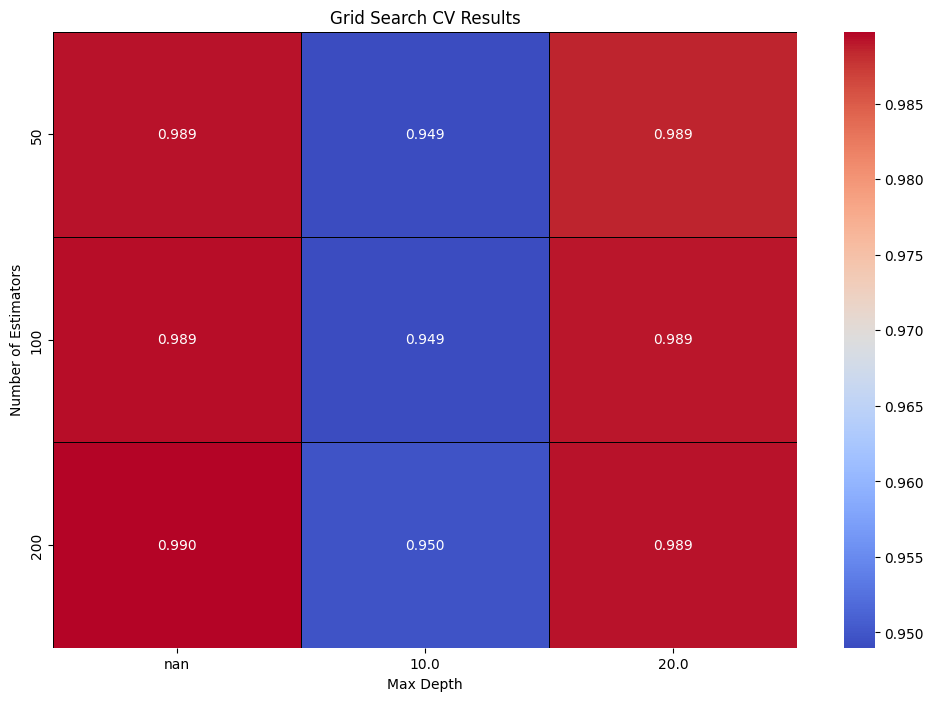


Cross Validation Scores (Accuracy): [0.99135447 0.99164265 0.98991354 0.99164265 0.98991354 0.98847262
 0.98904899 0.99308357 0.99164024 0.9901989 ]
Mean CV Accuracy: 0.9906911192837674
Standard Deviation of CV Accuracy: 0.0013396029171421772


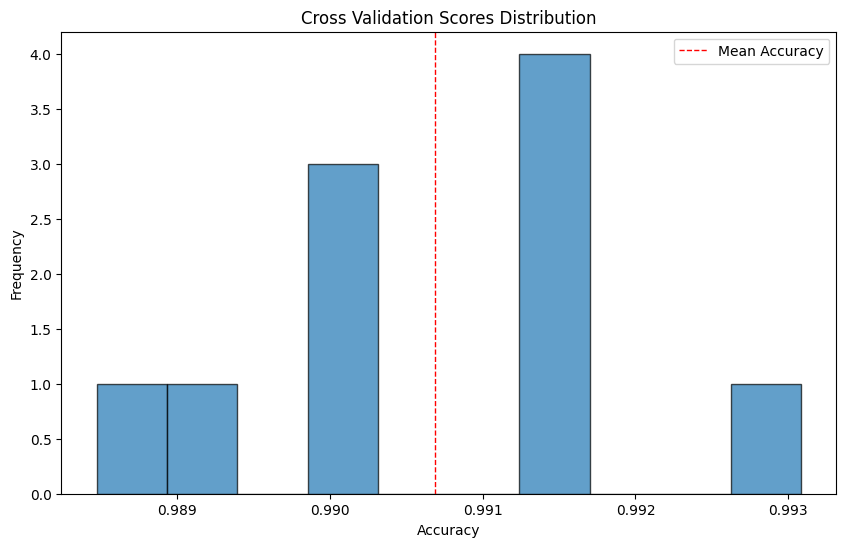

In [10]:
# Inisialisasi model RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Definisikan grid pencarian untuk parameter model
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
}

# Grid Search dengan 3-fold cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

# Model terbaik dan parameternya
best_rf = grid_search.best_estimator_
print("\nBest Parameters:", grid_search.best_params_)

# Plotkan heatmap untuk skor akurasi masing-masing kombinasi parameter
cv_results = grid_search.cv_results_

# Membuat dataframe untuk data hasil Grid Search
results_df = pd.DataFrame(cv_results)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    results_df.pivot(index='param_n_estimators', columns='param_max_depth', values='mean_test_score'),
    annot=True, fmt='.3f', cmap='coolwarm', linewidths=.5, linecolor='black'
)
plt.title('Grid Search CV Results')
plt.xlabel('Max Depth')
plt.ylabel('Number of Estimators')
plt.show()

# Lakukan cross-validation
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=10, scoring='accuracy')

# Tampilkan skor cross-validation
print("\nCross Validation Scores (Accuracy):", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())

# Plot histogram dari skor cross-validation
plt.figure(figsize=(10, 6))
plt.hist(cv_scores, bins=10, edgecolor='black', alpha=0.7)
plt.title('Cross Validation Scores Distribution')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.axvline(cv_scores.mean(), color='red', linestyle='dashed', linewidth=1, label='Mean Accuracy')
plt.legend()
plt.show()


10. CROSS VALIDATION SCORES

In [20]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Model terbaik dari Grid Search
best_rf = grid_search.best_estimator_

# Lakukan cross-validation
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=10, scoring='accuracy')

# Tampilkan skor cross-validation
print("\nCross Validation Scores (Accuracy):", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())

# Plot histogram dari skor cross-validation
plt.figure(figsize=(10, 6))
plt.hist(cv_scores, bins=10, edgecolor='black', alpha=0.7)
plt.title('Cross Validation Scores Distribution')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.axvline(cv_scores.mean(), color='red', linestyle='dashed', linewidth=1, label='Mean Accuracy')
plt.legend()
plt.show()



Cross Validation Scores (Accuracy): [0.99135447 0.99164265 0.98991354 0.99164265 0.98991354 0.98847262
 0.98904899 0.99308357 0.99164024 0.9901989 ]
Mean CV Accuracy: 0.9906911192837674
Standard Deviation of CV Accuracy: 0.0013396029171421772


11. EVALUASI MODEL

In [11]:
# Prediksi pada data uji
y_pred = best_rf.predict(X_test)

# Evaluasi Model
print("\nAccuracy on Test Data:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)


Accuracy on Test Data: 0.992507204610951

Classification Report:
               precision    recall  f1-score   support

      Normal       0.99      0.99      0.99      2128
 Stres Berat       0.99      0.99      0.99      2209
Stres Ringan       0.99      0.99      0.99      2146
Stres Sedang       0.99      0.99      0.99      2192

    accuracy                           0.99      8675
   macro avg       0.99      0.99      0.99      8675
weighted avg       0.99      0.99      0.99      8675


Confusion Matrix:
 [[2113    3    8    4]
 [   4 2195    5    5]
 [   3    6 2132    5]
 [   8    5    9 2170]]


12. CONFUSION MATRIX

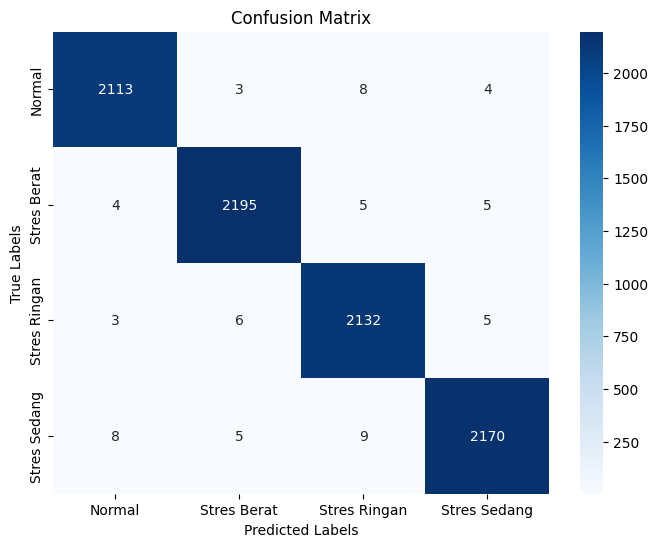

In [22]:
# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

13. EXPORT MODEL UNTUK DEPLOY KE RASPI

In [23]:
import joblib

# Export model ke file
model_path = "best_rf_model.pkl"
joblib.dump(best_rf, model_path)
print(f"Model disimpan ke: {model_path}")

Model disimpan ke: best_rf_model.pkl
